# Example of using Triple Collocation 
## to estimate the accuracy of measurements, given (at least) three independent observations of the same quantity

Stoffelen, Ad. "Toward the true near‐surface wind speed: Error modeling and calibration using triple collocation." Journal of geophysical research: oceans 103.C4 (1998): 7755-7766.

Qiao, Dejing, et al. "Uncertainty Characterization of Ground‐Based, Satellite, and Reanalysis Snow Depth Products Using Extended Triple Collocation." Water Resources Research 58.4 (2022): e2021WR030895.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Part 0: The triple collocation algorithm

In [2]:
def tricolo(measurements):
    
    Q = np.cov(measurements)
    
    var = []
    var.append ((Q[0,0] - Q[0,1]*Q[0,2] / Q[1,2]))
    var.append ((Q[1,1] - Q[0,1]*Q[1,2] / Q[0,2]))
    var.append ((Q[2,2] - Q[0,2]*Q[1,2] / Q[0,1]))

    var = np.array(var)
    var[var<0] = 0
    std = np.sqrt(var)
    
    return var,std,Q

# Part 1: example with toy data

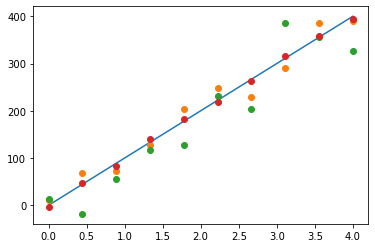

Estimated std: [23.03 45.03  0.  ]
Actual std: [25 50  5]


In [3]:
# mean and standard deviation
mu = np.array((0,0,0))
sigma = np.array((25,50,5))
N_samples = 10

time = np.linspace(0,4,N_samples) # yr
rate = 100 # m/yr
displacement = time * rate

measurement = []
for m,s in zip(mu,sigma):
    noise = np.random.normal(m, s, len(time))
    measurement.append (displacement + noise)

showPlots = True
if showPlots:
    plt.subplots()
    plt.plot(time, displacement)
    for m in measurement: plt.plot(time, m,'o')
    plt.show()



var,std,Q = tricolo(measurement)
print(f'Estimated std: {np.round(std,2)}')
print(f'Actual std: {sigma}')

### How much data do we need to get the method to work? Let's iterate to get a sense of convergence.

/home/bradlipovsky/anaconda3/envs/comcat/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/bradlipovsky/anaconda3/envs/comcat/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/bradlipovsky/anaconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Degrees of freedom <= 0 for slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bradlipovsky/anaconda3/envs/comcat/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/bradlipovsky/anaconda3/envs/comcat/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


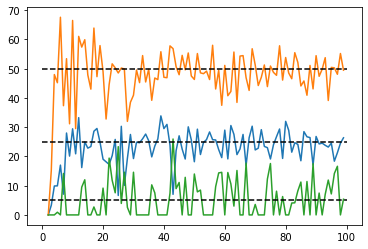

In [4]:
estimate = []
N_samples = 100
for N in range(N_samples):

    time = np.linspace(0,4,N) # yr
    rate = 100 # m/yr
    displacement = time * rate

    # mean and standard deviation
    mu = np.array((0,0,0))
    sigma = np.array((25,50,5))

    measurement = []
    for m,s in zip(mu,sigma):
        noise = np.random.normal(m, s, len(time))
        measurement.append (displacement + noise)

    varz,stds,Qs = tricolo(measurement)
    estimate.append(stds)
estimate = np.array(estimate)
plt.plot(estimate)
plt.plot([0,N_samples],[sigma[0], sigma[0]],'--k')
plt.plot([0,N_samples],[sigma[1], sigma[1]],'--k')
plt.plot([0,N_samples],[sigma[2], sigma[2]],'--k')

# Part 2: Using Ash's data from Figure 6 in his manuscript

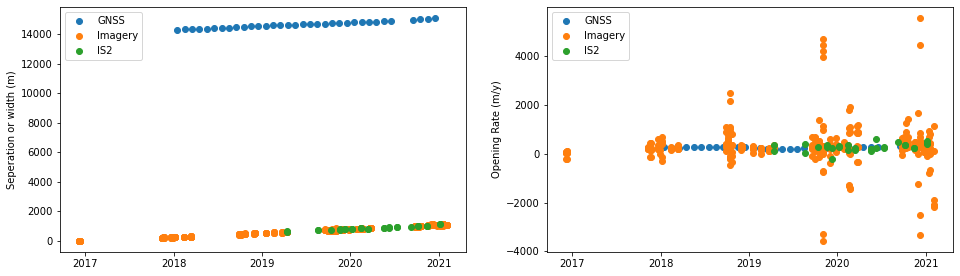

In [66]:
# Load the data and calculate velocities

import pickle5 as pickle
with open('fig6_data.pickle', 'rb') as f:
    x = pickle.load(f)
    
# t1 = x['GNSS_east_pre_calving_time']
# w1 = x['GNSS_east_pre_calving_sep']
# t2 = x['sat_east_pre_calving_time']
# w2 = x['sat_east_pre_calving_width']
# t3 = x['IS2_east_pre_calving_time']
# w3 = x['IS2_east_pre_calving_width']

t1 = x['GNSS_west_pre_calving_time']
w1 = x['GNSS_west_pre_calving_sep']
t2 = x['sat_west_pre_calving_time']
w2 = x['sat_west_pre_calving_width']
t3 = x['IS2_west_pre_calving_time']
w3 = x['IS2_west_pre_calving_width']

v1 = np.gradient(w1,t1)
v2 = np.gradient(w2,t2)
v3 = np.gradient(w3,t3)

plt.subplots(1,2,figsize=(16,4.5))
plt.subplot(121)
plt.plot(t1,w1,'o',label='GNSS')
plt.plot(t2,w2,'o',label='Imagery')
plt.plot(t3,w3,'o',label='IS2')
plt.ylabel('Seperation or width (m)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(t1,v1,'o',label='GNSS')
plt.plot(t2,v2,'o',label='Imagery')
plt.plot(t3,v3,'o',label='IS2')
plt.ylabel('Opening Rate (m/y)')
plt.legend()
plt.show()

### First issue to deal with: the opening rates from imagery are super noisy (for real, physical reasons, as Ash describes in the manuscript).  Let's bin these observations into the time steps of the GNSS data and then take the mean value.

In [67]:
# Option 1: use the bins as determined from the GNSS time steps
bins = np.linspace(min(t1),max(t1),len(t1))

# Option 2: interpolate GNSS onto a coarser (or finer) grid and use this time step
# bins = np.linspace(min(t1),max(t1),np.round(len(t1)/2).astype(int))
# v1_interp_fun = interp1d(t1,v1)
# v1i = v1_interp_fun(bins)

In [68]:
#half-baked idea to improve on np.gradient for our gappy data...

# def nangradient(t,y):
#     # calculate gradient, ignoring nans by using an unequal finite difference stencil
#     keep_these = ~np.isnan(y)
#     nan_list = np.isnan(y)
    
#     t,y = t[keep_these], y[keep_these]
#     v = np.zeros_like(t)
#     v[0] = (y[1] - y[0]) / (t[1] - t[0])
#     v[1] = (y[0])
    
# print(w2_binned)
# nangradient(w2_binned,bins)

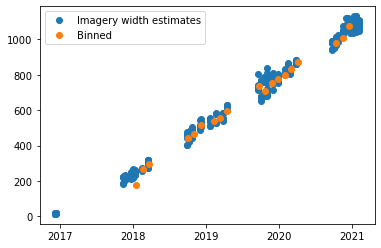

11
19


In [69]:
bin_indices = np.digitize(t2, bins)
w2_binned = np.zeros_like(bins)
for i in range( len(bins) ):
    sl = w2[bin_indices==i]
    if len(sl) > 0:
        w2_binned[i] = np.mean(sl)
    else:
        w2_binned[i] = np.nan

v2_binned = np.gradient(w2_binned,bins)
# v2_binned = nangradient(w2_binned,bins)

plt.subplots()
plt.plot(t2,w2,'o',label='Imagery width estimates')
plt.plot(bins,w2_binned,'o',label='Binned')
plt.legend()
plt.show()
# print(v2_binned)
print(sum(~np.isnan(v2_binned)))
print(sum(~np.isnan(w2_binned)))

### Next, more minor issues is that the IS2 estimates need to be binned

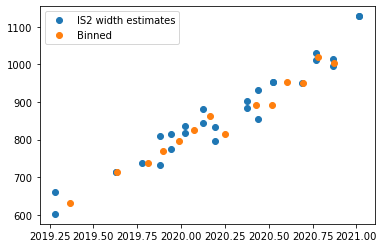

(34,)


array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan, 321.10460241, 313.14119125, 385.94254749,
       -62.38539474,          nan,          nan,          nan,
       342.50761703, 323.85856853, 384.97647756, 309.54631543,
                nan,          nan])

In [70]:
bin_indices = np.digitize(t3, bins)
w3_binned = np.zeros_like(bins)
for i in range( len(bins) ):
    sl = w3[bin_indices==i]
    if len(sl) > 0:
        w3_binned[i] = np.mean(sl)
    else:
        w3_binned[i] = np.nan
v3_binned = np.gradient(w3_binned,bins)

plt.subplots()
plt.plot(t3,w3,'o',label='IS2 width estimates')
plt.plot(bins,w3_binned,'o',label='Binned')
plt.legend()
plt.show()

print(v3_binned.shape)
v3_binned

In [71]:
# window = ~np.isnan(w3_binned)
# v3_binned = np.gradient(w3_binned[window],bins[window])
# v2_binned = v2_binned[window]
# v1i = v1i[window]
# t = bins[window]

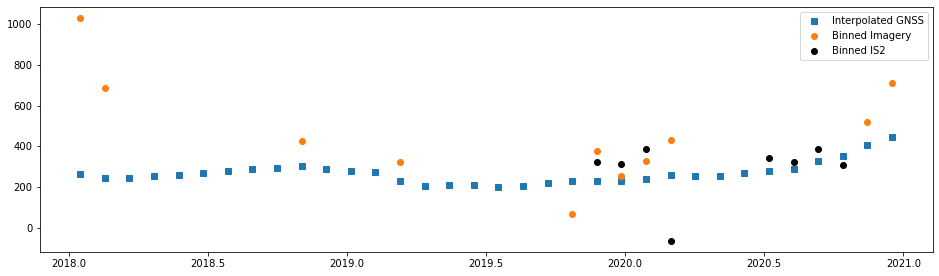

In [72]:
plt.subplots(figsize=(16,4.5))
plt.plot(bins,v1,'s',label='Interpolated GNSS')
plt.plot(bins,v2_binned,'o',label='Binned Imagery')
plt.plot(bins,v3_binned,'ok',markerfacecolor=None, label='Binned IS2')
plt.legend()
plt.show()

# Now that the data is cleaned up we can do 3c

In [73]:
measurements = np.vstack([v1,v2_binned,v3_binned]).T
keep = ~np.isnan(np.sum(measurements,axis=1))
measurements = measurements[keep,:].T
measurements.shape

(3, 4)

In [74]:
var,std,Q = tricolo(measurements)
print(std)

[ 4.11617639 45.76075228 89.80477528]
